<a href="https://colab.research.google.com/github/sajan-sarker/PyTorch_Practice_Codes/blob/main/PyTorch_Practice_2_ANN_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.3 MB/s eta 0:00:00


In [23]:
import pandas as pd
import torch
import optuna
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# set random seeds for reporductibility
torch.manual_seed(42)

Dataset Source: https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [16]:
import kagglehub
#fashion-mnist_train.csv
# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

df = pd.read_csv(path+'/fashion-mnist_train.csv')
df_test = pd.read_csv(path+'/fashion-mnist_test.csv')
print("Train Shape:",df.shape)
print("Test Shape:",df_test.shape)

Train Shape: (60000, 785)
Test Shape: (10000, 785)


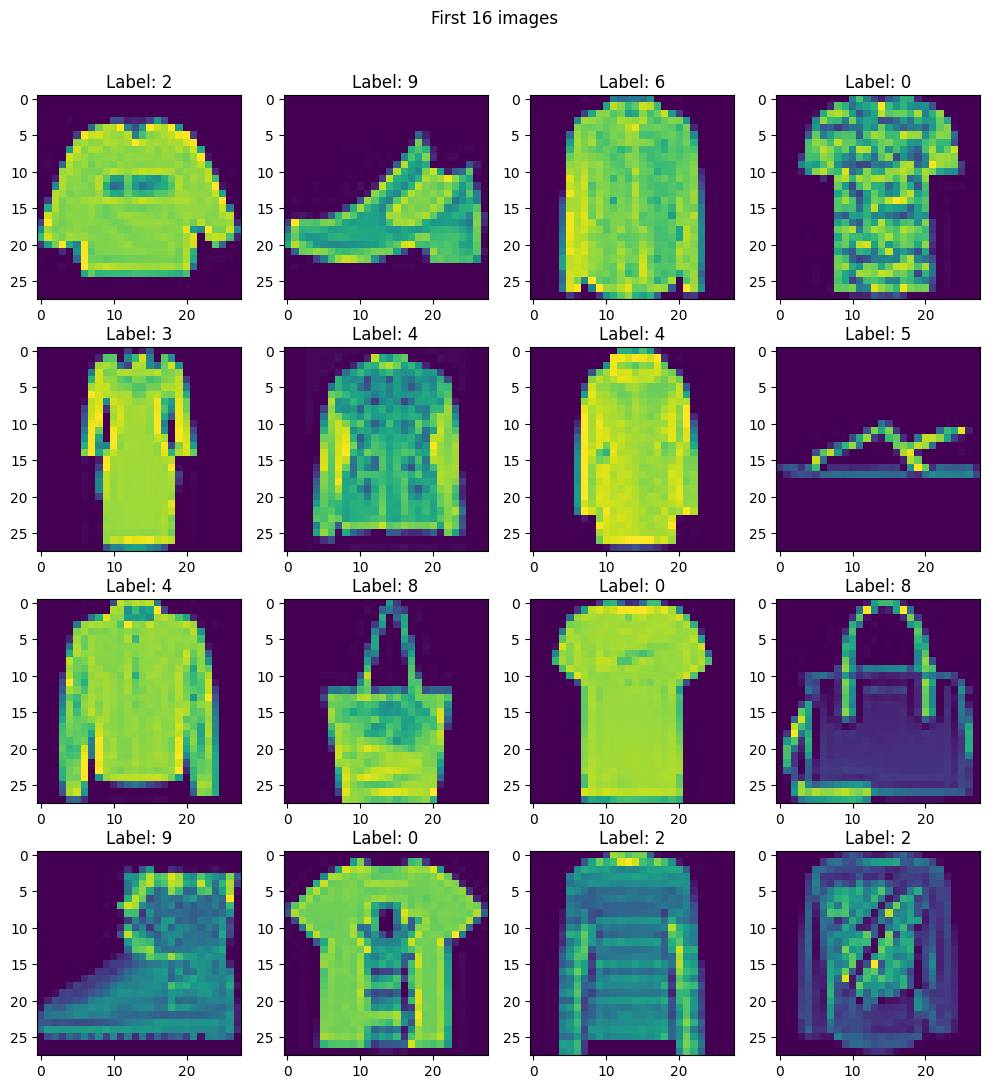

In [14]:
# create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 11))
fig.suptitle("First 16 images")

# plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df.iloc[i, 1:].values.reshape(28, 28) # rehsape 28x28
  ax.imshow(img)
  ax.set_title(f"Label: {df.iloc[i, 0]}")
plt.tight_layout(rect=[0,0,1,0.96]) # adjust layout to fit the title
plt.show()

In [17]:
# train test split
X_train = df.iloc[:, 1:].values
y_train = df.iloc[:, 0].values
X_test = df_test.iloc[:, 1:].values
y_test = df_test.iloc[:, 0].values

# scaling
X_train = X_train/255.0
X_test = X_test/255.0

In [19]:
class CustomDataset(Dataset):
  def __init__(self, features, labels):
    self.features = torch.FloatTensor(features)
    self.labels = torch.LongTensor(labels)

  def __len__(self):
    return self.features.shape[1]

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

In [20]:
# creating the model
class NN(nn.Module):
  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layers, dropout_rate=0.1):
    super().__init__()
    layers = []

    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_per_layers))
      layers.append(nn.BatchNorm1d(neurons_per_layers))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layers
    self.model = nn.Sequential(*layers)
    self.classifier = nn.Linear(neurons_per_layers, output_dim)

  def forward(self, X):
    features = self.model(X)
    return self.classifier(features)

In [34]:
def objective(trial,train_dataset, test_dataset, input_dim, output_dim):
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 4)
  neurons_per_layers = trial.suggest_categorical("neurons_per_layers", [16, 32, 64])
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_categorical("learning_rate",[0.0001, 0.001, 0.01])
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  model = NN(input_dim, output_dim, num_hidden_layers, neurons_per_layers).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # train model
  for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
      batch_X, batch_y = batch_X.to(device), batch_y.to(device) # move to gpu

      pred = model(batch_X)  # forward pass

      loss = criterion(pred, batch_y) # calculate loss

      optimizer.zero_grad() # back propagation
      loss.backward()

      optimizer.step()  # update grads

  # evaluation
  model.eval()
  total = 0
  correct = 0

  with torch.no_grad():
    for batch_X, batch_y in test_loader:
      batch_X, batch_y = batch_X.to(device), batch_y.to(device) # move to gpu

      pred = model(batch_X)  # forward pass

      _, predicted = torch.max(pred, 1)
      total += batch_y.shape[0]
      correct+= (predicted == batch_y).sum().item()
    accuracy = correct/total
  return accuracy

In [39]:
# hyperparameter tuning
study = optuna.create_study(direction='minimize')

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
input_dim = X_train.shape[1]
output_dim = 10
study.optimize(lambda trial: objective(trial, train_dataset, test_dataset, input_dim, output_dim), n_trials=50, n_jobs=3)

[I 2025-03-06 08:20:06,716] A new study created in memory with name: no-name-a5743d7d-962d-41a7-93e7-1148b70a8fb0
[I 2025-03-06 08:20:09,354] Trial 2 finished with value: 0.6415816326530612 and parameters: {'num_hidden_layers': 1, 'neurons_per_layers': 16, 'epochs': 30, 'learning_rate': 0.0001, 'batch_size': 64, 'weight_decay': 0.00014509592595623154}. Best is trial 2 with value: 0.6415816326530612.
[I 2025-03-06 08:20:10,440] Trial 3 finished with value: 0.6785714285714286 and parameters: {'num_hidden_layers': 4, 'neurons_per_layers': 64, 'epochs': 10, 'learning_rate': 0.01, 'batch_size': 128, 'weight_decay': 0.00036984651794044206}. Best is trial 2 with value: 0.6415816326530612.
[I 2025-03-06 08:20:10,803] Trial 1 finished with value: 0.7181122448979592 and parameters: {'num_hidden_layers': 3, 'neurons_per_layers': 32, 'epochs': 50, 'learning_rate': 0.0001, 'batch_size': 128, 'weight_decay': 1.32357007772985e-05}. Best is trial 2 with value: 0.6415816326530612.
[I 2025-03-06 08:20:1

In [42]:
study.best_value

0.3788265306122449

In [43]:
study.best_params

{'num_hidden_layers': 3,
 'neurons_per_layers': 16,
 'epochs': 20,
 'learning_rate': 0.0001,
 'batch_size': 64,
 'weight_decay': 0.0009966242307544845}